# <u>Bot Detection</u>

# 1. Data Collection and Integration

## 1.1. Imports

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import os,glob,sys
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold

## 1.2. Globals

In [2]:
DATASETS_DIR = 'Datasets'
SRC_DIR = 'src'
TWEETS_DIR = 'Tweets'
BOT_TWEETS_DIR = 'Bot_accounts_tweets'
GENUINE_TWEETS_DIR = 'Genuine_accounts_tweets'

In [3]:
# for organized printing only
class txt_format:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## 1.3. Loading Data and Modules

In [4]:
# genuine users => 0 , bots => 1
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, DATASETS_DIR)
os.chdir(dataset_dir)
# Loading users data
total_data = pd.DataFrame()
for File_Name in glob.glob("*_users.csv"):
    df = pd.read_csv(File_Name)
    if File_Name == 'genuine_accounts_users.csv':
        df['bot'] = 0
    elif File_Name == 'E13_users.csv' or File_Name == 'TFP_users.csv':
        df['bot'] = 0
        df['test_set_1'] = 0
        df['test_set_2'] = 0
    elif File_Name == 'fake_followers_users.csv':
        df['bot'] = 1
    elif 'social_spambots' in File_Name:
        df['bot'] = 1
    elif 'traditional_spambots' in File_Name:
        df['bot'] = 1
    else:
        print(File_Name)
    total_data = pd.concat([total_data,df], ignore_index = True, sort=False)

os.chdir(cwd)

### 1.3.1. Loading Tweets and Description

'run_full_process' is a binary variable that decides wheather running all notebooks cells will take a few hours. If marked with 1, will run:
* translation process using Yandex service - also limited by characters per day
* language detection process using Yandex service - also limited by characters per day
* BoW process
* finding most important words in description text field
* calculating the tweet features (not including the variation on Levenshtein distances. Takes some time)

otherwise, will skip it and use pre-made files.

'run_tweet_var_calculation' allows you to calculate the variance of Levenshtein Distance between tweets of a user. To do this, change value to 1. **Note:** This calculation takes hours

In [5]:
run_full_process = 0

In [6]:
run_tweet_var_calculation = 0

In [7]:
user_data_file_path = os.path.join(dataset_dir, 'tweet_features_filled1.csv')
user_data = pd.read_csv(user_data_file_path)
user_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
levenshtein_data_file_path = os.path.join(dataset_dir, 'tweet_var_data_full_with_threshold.csv')
levenshtein_data = pd.read_csv(levenshtein_data_file_path)

In [9]:
description_data_file_path = os.path.join(dataset_dir, 'description_data_set2.csv')
description_df = pd.read_csv(description_data_file_path)
if(run_full_process):
    description_df = description_df[['Unnamed: 0', 'id', 'lang', 'description', 'bot','test_set_1', 'test_set_2']]    

In [10]:
if(not run_full_process):
    count_vectors_df = pd.DataFrame()
    count_vectors_files_names = [file 
                                 for file in os.listdir(dataset_dir) 
                                 if os.path.isfile(os.path.join(dataset_dir, file)) and 
                                 'count_df_' in file
                                ]
    
    for count_vectors_file_name in count_vectors_files_names:
        count_vectors_data_file_path = os.path.join(dataset_dir, count_vectors_file_name)
        count_df = pd.read_csv(count_vectors_data_file_path)
        count_vectors_df = pd.concat([count_vectors_df,count_df], ignore_index = True)
    count_vectors_df.drop('Unnamed: 0.1', axis=1, inplace=True)

### 1.3.2.  Loading Modules

In [11]:
modules_path = os.path.join(os.getcwd(),SRC_DIR)
if modules_path not in sys.path:
    sys.path.append(modules_path)

## 1.4. Data Undestanding

In [12]:
# understanding data types
total_data.dtypes

id                                      int64
name                                   object
screen_name                            object
statuses_count                          int64
followers_count                         int64
friends_count                           int64
favourites_count                        int64
listed_count                            int64
url                                    object
lang                                   object
time_zone                              object
location                               object
default_profile                       float64
default_profile_image                 float64
geo_enabled                           float64
profile_image_url                      object
profile_banner_url                     object
profile_use_background_image          float64
profile_background_image_url_https     object
profile_text_color                     object
profile_image_url_https                object
profile_sidebar_border_color      

In [13]:
#training size:
len(total_data.index)

16318

In [14]:
total_data.head(10)

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2,bot,dataset
0,1502026416,TASUKU HAYAKAWA,0918Bask,2177,208,332,265,1,NaN,ja,...,NaN,NaN,Tue Jun 11 11:20:35 +0000 2013,2013-06-11 13:20:35,2015-05-02 06:41:46,2016-03-15 15:53:47,0.0,0.0,0,NaN
1,2492782375,ro_or,1120Roll,2660,330,485,3972,5,NaN,ja,...,NaN,NaN,Tue May 13 10:37:57 +0000 2014,2014-05-13 12:37:57,2015-05-01 17:20:27,2016-03-15 15:53:48,0.0,0.0,0,NaN
2,293212315,bearclaw,14KBBrown,1254,166,177,1185,0,NaN,en,...,NaN,NaN,Wed May 04 23:30:37 +0000 2011,2011-05-05 01:30:37,2015-05-01 18:48:28,2016-03-15 15:53:48,0.0,0.0,0,NaN
3,191839658,pocahontas farida,wadespeters,202968,2248,981,60304,101,http://t.co/rGV0HIJGsu,en,...,NaN,NaN,Fri Sep 17 14:02:10 +0000 2010,2010-09-17 16:02:10,2015-05-01 13:55:16,2016-03-15 15:53:48,0.0,0.0,0,NaN
4,3020965143,Ms Kathy,191a5bd05da04dc,82,21,79,5,0,NaN,en,...,NaN,NaN,Fri Feb 06 04:10:49 +0000 2015,2015-02-06 05:10:49,2015-05-02 01:17:32,2016-03-15 15:53:48,0.0,0.0,0,NaN
5,2157382005,JO,19_Joanne_87,12915,641,1066,1568,7,NaN,en,...,NaN,NaN,Mon Oct 28 16:08:18 +0000 2013,2013-10-28 17:08:18,2015-05-01 13:46:12,2016-03-15 15:53:49,0.0,0.0,0,NaN
6,1947320929,❄McKayla❄,1Dniallprincess,13676,1042,2000,19012,7,NaN,en,...,NaN,NaN,Tue Oct 08 15:59:30 +0000 2013,2013-10-08 17:59:30,2015-05-01 13:35:33,2016-03-15 15:53:49,0.0,0.0,0,NaN
7,255846106,Giselle,1GisellePizarro,61294,561,118,590,4,https://t.co/v4qQQ0XDjd,es,...,NaN,NaN,Tue Feb 22 04:37:34 +0000 2011,2011-02-22 05:37:34,2015-05-01 16:46:13,2016-03-15 15:53:49,0.0,0.0,0,NaN
8,1733095801,Nicole Romany,1Nicoleromany,4854,337,256,1407,4,NaN,en,...,NaN,NaN,Thu Sep 05 20:52:02 +0000 2013,2013-09-05 22:52:02,2015-05-01 13:16:34,2016-03-15 15:53:50,0.0,0.0,0,NaN
9,1336097480,Fallen Angel,1_DErika,2408,421,338,2227,5,NaN,en,...,NaN,NaN,Mon Apr 08 08:37:42 +0000 2013,2013-04-08 10:37:42,2015-05-02 03:39:39,2016-03-15 15:53:50,0.0,0.0,0,NaN


In [15]:
# # of basic user features (including target)
total_data.columns.size

44

### 1.4.1. Perliminary Data Visualization and Statistics

#### 1.4.1.1. Class Distribution

In [16]:
total_data['bot'].value_counts()

1    10894
0     5424
Name: bot, dtype: int64

#### 1.4.1.2. Language Histogram

In [17]:
print ("-------------------------------")
print ("Histogram for 'lang'")
print ("-------------------------------")
print (total_data['lang'].value_counts())
print ("")

-------------------------------
Histogram for 'lang'
-------------------------------
en                    11950
it                     2577
es                      374
en-gb                   122
pt                       71
fr                       46
ru                       46
ja                       34
zh-tw                    17
tr                       16
de                       13
id                       12
ko                        9
nl                        7
en-GB                     4
ar                        4
zh-TW                     3
Select Language...        2
zh-cn                     2
da                        2
xx-lc                     1
en-AU                     1
el                        1
gl                        1
fil                       1
sv                        1
pl                        1
Name: lang, dtype: int64



# 2. Data Preparation and Cleaning

## 2.1. Unique Values
* id, screen_name are unique - **different value for each record**
* contributors_enabled, follow_request_sent , following , notifications - **zero unique values** (NULL)
* verified, protected, profile_use_background_image, profile_background_tile, is_translator, geo_enabled, default_profile, default_profile_image - **single unique value**

In [18]:
total_data.nunique()

id                                    16318
name                                  15711
screen_name                           16318
statuses_count                         5030
followers_count                        2175
friends_count                          2171
favourites_count                       2632
listed_count                            229
url                                    3066
lang                                     27
time_zone                               114
location                               4955
default_profile                           1
default_profile_image                     1
geo_enabled                               1
profile_image_url                     16174
profile_banner_url                     6091
profile_use_background_image              1
profile_background_image_url_https     7669
profile_text_color                      628
profile_image_url_https               15240
profile_sidebar_border_color            341
profile_background_tile         

### Remove columns with zero unique values (NULL values only )
* contributors_enabled 
* follow_request_sent 
* following 
* notifications 

In [19]:
for col_name in total_data.columns:
    if total_data[col_name].nunique() < 1:
        print('removing ', col_name)
        total_data.drop(col_name, axis = 1, inplace = True)

removing  follow_request_sent
removing  notifications
removing  contributors_enabled
removing  following


### Removing irrelevant columns : 
* dataset (dataset name) 
* crawled_at (date the data was crawled)

In [20]:
total_data.drop(['dataset','crawled_at'], axis = 1, inplace = True)

## 2.2. NULL Values

Visualizing NULL count for each column

In [21]:
import Missing_Values_Lib

In [22]:
try:
    import missingno as msno
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install missingno --user
    import missingno as msno       

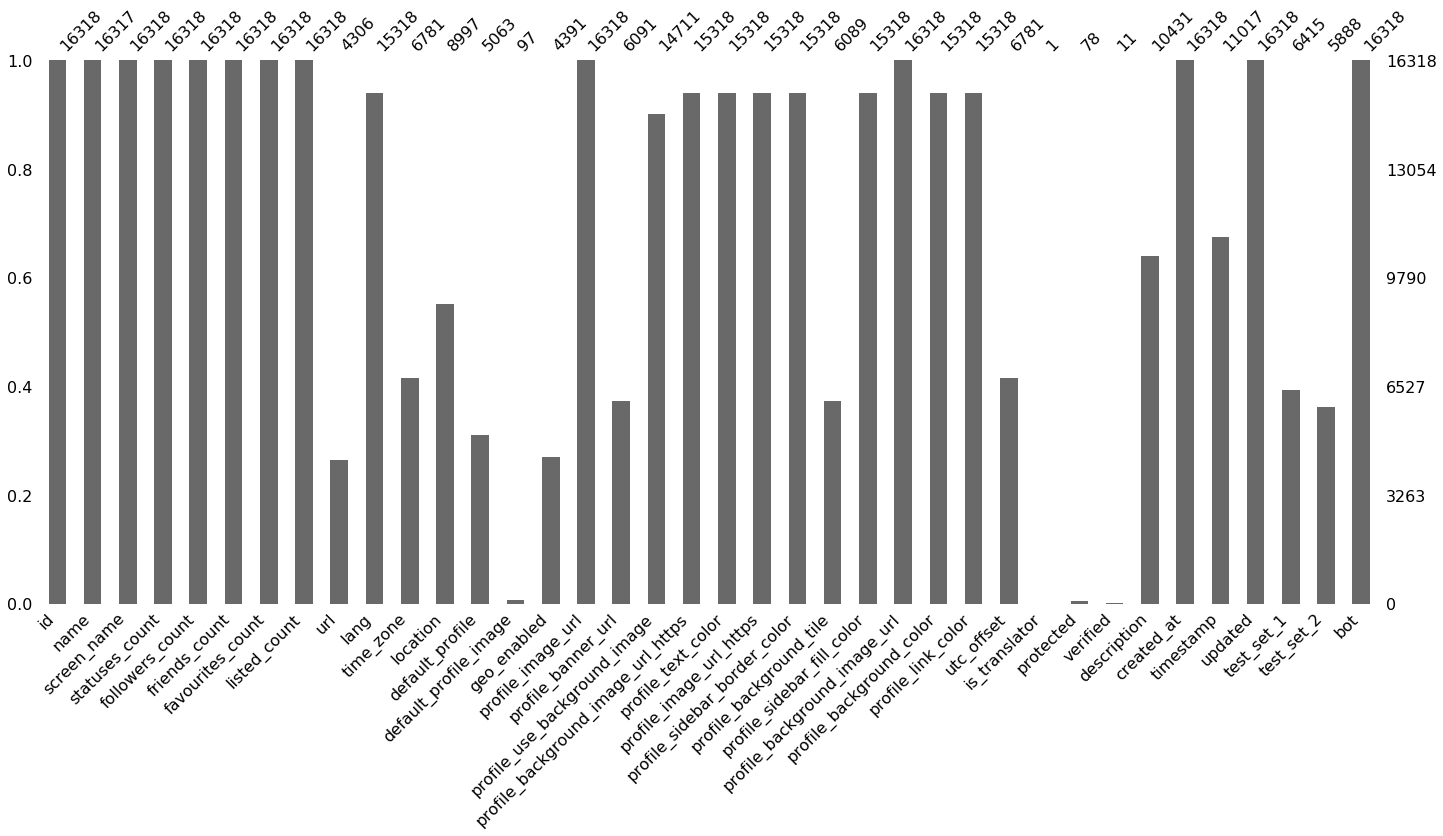

In [23]:
msno.bar(total_data)

In the graph above, each number represents the non-null count for a certain column

### Total missing values

In [24]:
np.sum(np.sum(total_data.isnull()))

188259

### Removing columns with more then 16,000 null values : 
* default_profile_image
* is_translator
* protected
* verified

In [25]:
threshold = 16000
for col_name in total_data.columns:
    if np.sum(total_data[col_name].isnull()) >= threshold:
        print('removing ', col_name)
        total_data.drop(col_name, axis = 1, inplace = True)

removing  default_profile_image
removing  is_translator
removing  protected
removing  verified


After understanding the data type in each column, we replace the Nulls with the appropriate value

In [26]:
Missing_Values_Lib.Fill_Missing(total_data)
np.sum(np.sum(total_data.isnull()))

0

This is a perliminary filling. More precise work will be done on feature engineering section.

# 3. Feature Engineering

## 3.1. Numeric Features

In [27]:
import General_Lib

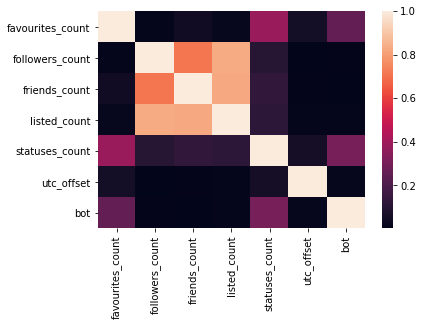

In [28]:
# The following features are the numeric features from user data (before engineering)
numeric_features_list = ['favourites_count',
                 'followers_count',
                 'friends_count',
                 'listed_count',
                 'statuses_count',
                 'utc_offset',
                 'bot']

corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, numeric_features_list)

**No apparent connection between main numeric features to the target**<br>
**We can see there is a high correlation between:**
1. listed_count - followers count 
2. listed_count - friends count 
3. friends count - followers count

In [29]:
corr_mtx['bot']

favourites_count    0.256424
followers_count     0.007785
friends_count       0.003983
listed_count        0.012425
statuses_count      0.303526
utc_offset          0.016984
bot                 1.000000
Name: bot, dtype: float64

**Each numeric feature is binned in order to get better correlation with the target feature on the following section. Features getting the highest correlation will replace current used features and will be added to the list below for future use:**

In [30]:
new_numeric_features = []

### 3.1.1. favourites_count

Text(0, 0.5, 'Count')

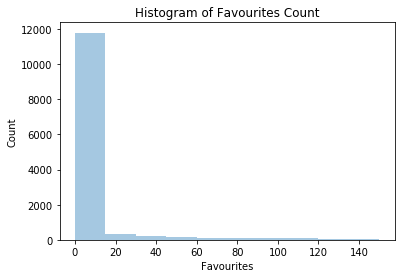

In [31]:
%matplotlib inline

sns.distplot(total_data[total_data.favourites_count<=150].favourites_count, bins = 10, kde = False)
plt.title('Histogram of Favourites Count')
plt.xlabel('Favourites')
plt.ylabel('Count')

**'0' has the highest frequency. We'll bin binarily if the value is 0 or not**

In [32]:
total_data['is_favourite'] = total_data['favourites_count'] > 0
print("new feature - target correlation is:",
      total_data['is_favourite'].corr(total_data['bot']))
print("old feature - target correlation is:",
        total_data['favourites_count'].corr(total_data['bot']))

new feature - target correlation is: -0.821319069480884
old feature - target correlation is: -0.25642436189065293


In [33]:
new_numeric_features.append('is_favourite')

### 3.1.2. followers_count

Text(0, 0.5, 'Count')

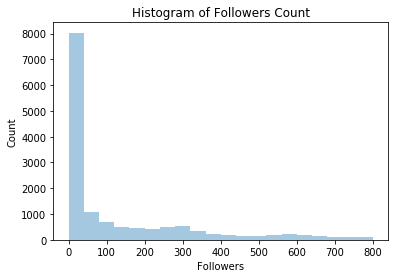

In [34]:
%matplotlib inline

sns.distplot(total_data[total_data.followers_count<=800].followers_count, bins = 20, kde = False)
plt.title('Histogram of Followers Count')
plt.xlabel('Followers')
plt.ylabel('Count')

<Figure size 432x288 with 0 Axes>

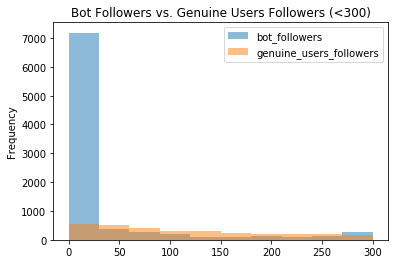

In [35]:
df_followers_count = total_data[total_data.followers_count<=300]
df_count = pd.DataFrame({'bot_followers': df_followers_count[df_followers_count.bot==1].followers_count,
                   'genuine_users_followers': df_followers_count[df_followers_count.bot==0].followers_count},
                   columns=['bot_followers', 'genuine_users_followers'])
plt.figure();
df_count.plot.hist(title = 'Bot Followers vs. Genuine Users Followers (<300)',bins= 10,alpha=0.5)  

In [36]:
print("Feature-target correlation:",total_data['followers_count'].corr(total_data['bot']))

Feature-target correlation: -0.0077853679420832825


**Binning to 5 equal width buckets**

In [37]:
bin_followers_count= General_Lib.Binning(total_data['followers_count'],5)
print("Feature-target correlation:",bin_followers_count.corr(total_data['bot']))

Feature-target correlation: 0.002668162599855367


**Binning to 5 <u>un</u>equal width buckets**

In [38]:
total_data['bin_followers_count'] = General_Lib.Binning(total_data['followers_count'],
                                                        -1, 
                                                        bin_seq = [0,12,20,30,100,np.inf])

total_data.bin_followers_count = total_data.bin_followers_count.astype(int)
print("Feature-target correlation:",total_data['bin_followers_count'].corr(total_data['bot']))

Feature-target correlation: -0.5266178365117588


**We chose the bins by choosing the binning that maximizes the correlation to the target.**

In [39]:
warnings.filterwarnings("ignore", category=FutureWarning) 
#only the following block yielding futureWraning beacuse of future change in scipy stats behavior (no way to fix it)

Text(0, 0.5, 'Count')

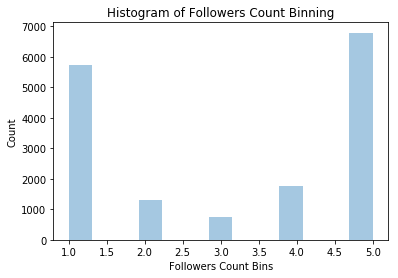

In [40]:
%matplotlib inline

sns.distplot(total_data['bin_followers_count'], kde = False)
plt.title('Histogram of Followers Count Binning')
plt.xlabel('Followers Count Bins')
plt.ylabel('Count')

In [41]:
warnings.filterwarnings("always", category=FutureWarning)  #restoring the default mode of warnings

In [42]:
new_numeric_features.append('bin_followers_count')

### 3.1.3. friends_count

Text(0, 0.5, 'Count')

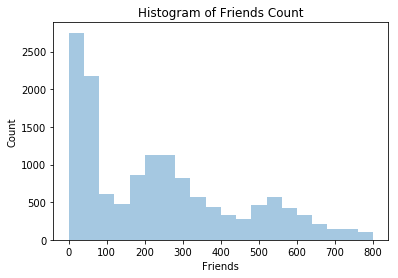

In [43]:
%matplotlib inline

sns.distplot(total_data[total_data.friends_count<=800].friends_count, bins = 20, kde = False)
plt.title('Histogram of Friends Count')
plt.xlabel('Friends')
plt.ylabel('Count')

<Figure size 432x288 with 0 Axes>

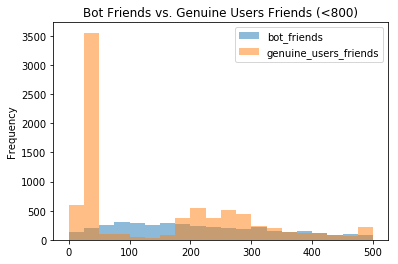

In [44]:
df_friends_count = total_data[total_data.friends_count<=500]
df_count = pd.DataFrame({'bot_friends': df_friends_count[df_friends_count.bot==0].friends_count,
                   'genuine_users_friends': df_friends_count[df_friends_count.bot==1].friends_count},
                   columns=['bot_friends', 'genuine_users_friends'])
plt.figure();
df_count.plot.hist(title = 'Bot Friends vs. Genuine Users Friends (<800)',bins= 20,alpha=0.5)                         

In [45]:
print("Feature-target correlation:",total_data['friends_count'].corr(total_data['bot']))

Feature-target correlation: 0.003982890161110999


**Binning to 20 equal width buckets**

In [46]:
bin_friends_count = General_Lib.Binning(total_data['friends_count'],20)
print("Feature-target correlation:",bin_friends_count.corr(total_data['bot']))

Feature-target correlation: 0.003472445260213213


**Binning to 5 <u>un</u>equal width buckets**

In [47]:
total_data['bin_friends_count'] = General_Lib.Binning(total_data['friends_count'],
                                                      -1, 
                                                      bin_seq = [0,2,10,50,90,np.inf])
print("Feature-target correlation:",total_data['bin_friends_count'].corr(total_data['bot']))

Feature-target correlation: -0.2963181531344148


In [48]:
total_data['bin_friends_count'].value_counts(dropna=False)

5    11223
3     4012
4      572
1      447
2       64
Name: bin_friends_count, dtype: int64

In [49]:
new_numeric_features.append('bin_friends_count')

### 3.1.4. listed_count

Text(0, 0.5, 'Count')

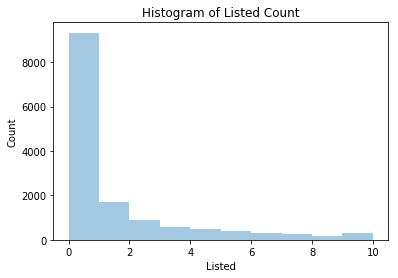

In [50]:
%matplotlib inline

sns.distplot(total_data[total_data.listed_count<=10].listed_count, bins = 10, kde = False)
plt.title('Histogram of Listed Count')
plt.xlabel('Listed')
plt.ylabel('Count')

In [51]:
print("Feature-target correlation:",total_data['listed_count'].corr(total_data['bot']))

Feature-target correlation: -0.012424547788108302


**Binary binning if the value of listed_count feature is zero or not** 

In [52]:
total_data['is_listed_count'] = total_data['listed_count'] > 0
print("Feature-target correlation:",total_data['is_listed_count'].corr(total_data['bot']))

Feature-target correlation: -0.330064262335266


**Binning to 5 equal width buckets**

In [53]:
listed_count_binning = General_Lib.Binning(total_data['listed_count'],8)
print("Feature-target correlation:",listed_count_binning.corr(total_data['bot']))

Feature-target correlation: 0.003713323579452202


**Binning to 8 <u>un</u>equal width buckets**

In [54]:
total_data['listed_count_binning'] = General_Lib.Binning(total_data['listed_count'],
                                                         -1, 
                                                         bin_seq = [0,2,10,50,200,300,500,1000,np.inf])
total_data.listed_count_binning = total_data.listed_count_binning.astype(int)
print("Feature-target correlation:",total_data['listed_count_binning'].corr(total_data['bot']))

Feature-target correlation: -0.1899239510411038


In [55]:
new_numeric_features.append('is_listed_count')

### 3.1.5. statuses_count

Text(0, 0.5, 'Count')

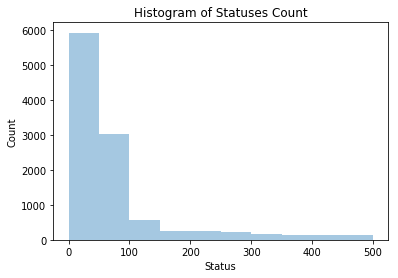

In [56]:
%matplotlib inline

sns.distplot(total_data[total_data.statuses_count<=500].statuses_count, bins = 10, kde = False)
plt.title('Histogram of Statuses Count')
plt.xlabel('Status')
plt.ylabel('Count')

In [57]:
print("Feature-target correlation:",total_data['statuses_count'].corr(total_data['bot']))

Feature-target correlation: -0.30352625162999897


**Binning to 3 unequal width buckets**

In [58]:
total_data['statuses_count_binning'] = General_Lib.Binning(total_data['statuses_count'],
                                                           -1, 
                                                           bin_seq = [0,80,300, np.inf])
total_data.statuses_count_binning = total_data.statuses_count_binning.astype(int)
print("Feature-target correlation:",total_data['statuses_count_binning'].corr(total_data['bot']))

Feature-target correlation: -0.7152237317990712


**Binning to 50 equal width buckets**

In [59]:
statuses_count_binning = General_Lib.Binning(total_data['statuses_count'],50)
print("Feature-target correlation:",statuses_count_binning.corr(total_data['bot']))

Feature-target correlation: -0.25368563083616585


**As we can see binning 3 buckets has given us great correlation to the target**

In [60]:
new_numeric_features.append('statuses_count_binning')

### 3.1.6. utc_offset

Text(0, 0.5, 'Count')

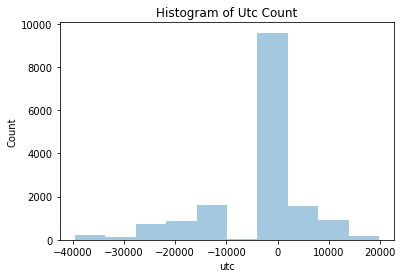

In [61]:
%matplotlib inline

sns.distplot(total_data[total_data.utc_offset<=20000].utc_offset, bins = 10, kde = False)
plt.title('Histogram of Utc Count')
plt.xlabel('utc')
plt.ylabel('Count')

<Figure size 432x288 with 0 Axes>

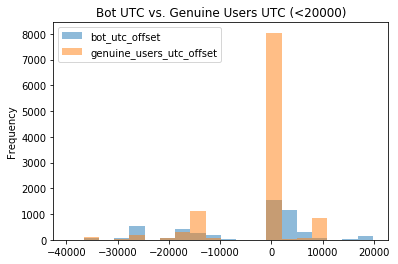

In [62]:
df_utc_offset = total_data[total_data.utc_offset<=20000]
df_count = pd.DataFrame({'bot_utc_offset': df_utc_offset[df_utc_offset.bot==0].utc_offset,
                   'genuine_users_utc_offset': df_utc_offset[df_utc_offset.bot==1].utc_offset},
                   columns=['bot_utc_offset', 'genuine_users_utc_offset'])
plt.figure();
df_count.plot.hist(title = 'Bot UTC vs. Genuine Users UTC (<20000)',bins= 20,alpha=0.5)                         

In [63]:
print("Feature-target correlation:",total_data['utc_offset'].corr(total_data['bot']))

Feature-target correlation: -0.01698365201935602


**Binning to 20 equal width buckets**

In [64]:
utc_offset_binning_1 = General_Lib.Binning(total_data['utc_offset'],20)
print("Feature-target correlation:",utc_offset_binning_1.corr(total_data['bot']))

Feature-target correlation: 0.03256158309843272


**Binning to 3 uequal width buckets**

In [65]:
utc_offset_binning_2 = General_Lib.Binning(total_data['utc_offset'],
                                           -1, 
                                           bin_seq = [-30000, 0, 10000, 20000])
print("Feature-target correlation:",utc_offset_binning_2.corr(total_data['bot']))

Feature-target correlation: -0.18487726729604395


**Binary binning if utc_offset is greater than zero or not**

In [66]:
total_data['is_utc_offset'] = total_data['utc_offset'] > 0
print("Feature-target correlation:",total_data['is_utc_offset'].corr(total_data['bot']))

Feature-target correlation: -0.36960636489833304


**Binary binning has provided the best correlation to the target**

In [67]:
new_numeric_features.append('is_utc_offset')

### 3.1.7. New Numeric Features Correlation

Correlation matrix of high correlated features

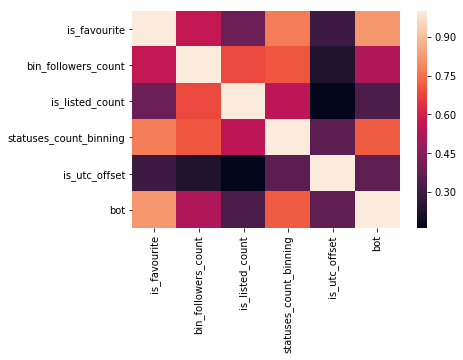

In [68]:
new_numeric_features.append('bot')
corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, new_numeric_features)

In [69]:
corr_mtx['bot']

is_favourite              0.821319
bin_followers_count       0.526618
is_listed_count           0.330064
statuses_count_binning    0.715224
is_utc_offset             0.369606
bot                       1.000000
Name: bot, dtype: float64

## 3.2. Date and Time

**Time and date features:** 
* created_at
* timestamp 
* updated 

We'll parse time and dates features to int features.

In [70]:
import Date_Parser_Lib

### 3.2.1. created_at feature

#### Created_at feature contains two date formats:
1. Day Month Day_in_month Hour:Minute:Seconds Time zone Year.
 * For example: Wed Jul 04 12:30:03 +0000 2007
2. Seconds from epoch
 * For example: 1183552203000L

**We will parse seconds from epoch format to the format described in bullet number 1. <br>
Then we will parse the updated feature to create new 7 numeric features:**
1. day of the week
2. month
3. day in month
4. hour
5. minute
6. second
7. year


In [71]:
feature_name = 'created_at'

**Check_For_Date_Format:** analyze the feature date format. <br>
<u>Return value: </u>
* seconds_from_epoch_data - samples contains seconds from epoch date format. <br>
* regular_date_format_data - all the remains samples.

In [72]:
seconds_from_epoch_data,regular_date_format_data = Date_Parser_Lib.Check_For_Date_Format(total_data, 
                                                                                         feature_name)

is all time stamp that does not contains +0000 are seconds from epoch format? True
Number of rows formatted as seconds from epoch: 1000
Number of rows formatted as regular date: 15318
is seconds from epoch + regular data = all data? True


#####  parse seconds from epoch date format 
* ignoring time zone (+0000 on every row).
* Convert seconds from epoch to regular date format
* Example of seconds from epoch date format: 1183552203000L

In [73]:
seconds_from_epoch_data['created_at'].head(5)

13726    1183552203000L
13727    1185440851000L
13728    1192725360000L
13729    1196614406000L
13730    1209536534000L
Name: created_at, dtype: object

**Convert seconds from epoch date format to regular format**

In [74]:
date_format_ceated_at = '%a %b %d %H:%M:%S +0000 %Y'
seconds_from_epoch_data[feature_name] = seconds_from_epoch_data[feature_name].apply(
                                        Date_Parser_Lib.convert_seconds_from_epoch_to_date_format,
                                        args = (date_format_ceated_at,))

seconds_from_epoch_data['created_at'].head(5)

13726    Wed Jul 04 12:30:03 +0000 2007
13727    Thu Jul 26 09:07:31 +0000 2007
13728    Thu Oct 18 16:36:00 +0000 2007
13729    Sun Dec 02 16:53:26 +0000 2007
13730    Wed Apr 30 06:22:14 +0000 2008
Name: created_at, dtype: object

**Concatenate the records**

In [75]:
total_data = pd.concat([seconds_from_epoch_data,regular_date_format_data])

**validate there is'nt any seconds from epoch format **

In [76]:
Date_Parser_Lib.Rows_Contain_Seconds_From_Epoch_Format(total_data,feature_name)

0

**Parse created_at column to create new numeric features**

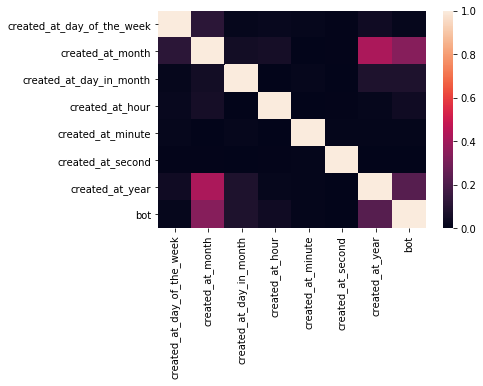

In [77]:
new_features_names,features_corr = Date_Parser_Lib.Parse_Feature_and_Print_Corr(total_data, 
                                                                  feature_name, 
                                                                  'bot', 
                                                                  date_format_ceated_at)

**New features correlation**

In [78]:
features_corr['bot']

created_at_day_of_the_week    0.013283
created_at_month              0.337823
created_at_day_in_month       0.081095
created_at_hour               0.041911
created_at_minute             0.010460
created_at_second             0.002967
created_at_year               0.226520
bot                           1.000000
Name: bot, dtype: float64

* **we cannot rely on the created year, as new bots created  all the time.**<br>
* **we will check the created_at_month feature<br>**
 * We assume maybe there is a connection between the created month to bot accounts <br>
* **There isn't a distinct connection between all the remains new features to the target feature.**

In [79]:
total_data[total_data['bot']==1]['created_at_month'].value_counts(dropna = False)

2     3217
3     2009
6     1468
1     1419
5      489
9      484
7      467
8      425
4      311
10     213
12     200
11     192
Name: created_at_month, dtype: int64

In [80]:
total_data[total_data['bot']==0]['created_at_month'].value_counts(dropna = False)

1     506
3     478
6     472
4     470
11    460
10    458
2     455
7     453
12    450
5     446
8     393
9     383
Name: created_at_month, dtype: int64

**February and March months are the most frequent months for bot accounts creation** <br>
**Binning according to those months**

In [81]:
total_data['is_february_march'] = (total_data['created_at_month'] == 2) | (total_data['created_at_month'] == 3)
print("Feature-target correlation:",total_data['is_february_march'].corr(total_data['bot']))

Feature-target correlation: 0.29902045981090675


**Binning according to top 4 months for bot accounts creation**

In [82]:
top_bot_months = [1,2,3,6]
total_data['is_top_month'] = total_data.apply(lambda x: 
                                              1 if x['created_at_month'] in top_bot_months 
                                              else 0,
                                             axis = 1)
print("Feature-target correlation:",total_data['is_top_month'].corr(total_data['bot']))

Feature-target correlation: 0.3797496310780214


**We managed to create new feature with correlation a little higher from the month feature. **

#### Remove created_at feature

In [83]:
total_data.drop([feature_name], axis = 1, inplace = True)

### 3.2.2. Updated column

**This column was added by the researchers and it is the same value at each dataset file.<br> 
We will remove this feature.**

In [84]:
total_data.drop(['updated'], axis = 1, inplace = True)

### 3.2.3. timestamp column

**This column was added by the researchers and isn't part of twitter's API.<br> 
We will remove this feature.**

In [85]:
total_data.drop(['timestamp'], axis = 1, inplace = True)

## 3.3. Textual User Features (without description)

 We devided the text features to 3 groups:
* Color features
* Location feature
* General text features

each group was treated in a slightly different way.

#### Text Features List

In [86]:
groups_types = total_data.columns.to_series().groupby(df.dtypes).groups
str_cols_names = [v 
                  for k, v in groups_types.items() 
                  if k.name == 'object'][0]

if 'profile_text_color' not in str_cols_names:
    str_cols_names = str_cols_names.append(pd.Index(['profile_text_color']))

print('{0}{1}{2}{3}{3}'.format(txt_format.BOLD,
                               txt_format.UNDERLINE,
                               'Text features:',
                               txt_format.END))

for col_name in str_cols_names:
    print(col_name)

Text features:
name
screen_name
url
lang
time_zone
location
profile_image_url
profile_banner_url
profile_background_image_url_https
profile_text_color
profile_image_url_https
profile_sidebar_border_color
profile_sidebar_fill_color
profile_background_image_url
profile_background_color
profile_link_color
description


### 3.3.1. General Text Features

For each general text feature we added 5 new numeric features:
* <u>Replace a string with unique value:</u> 
  * defined unique mapping from feature values to int and apply to the feature values.
* <u>Replace missing values by unique mapping by mode:</u>  
  * For the features created by the unique values, there are missing values (marked as enpty string). We will replace those values by mode. 
  * We split the mode replacement to two options: 
   * If all the nan values is of bot account: replace the missing values by the bot mode value of the feature.    
   * else replace by feature mode. 
* <u>Replace missing values by unique mapping by distribution:</u> 
 * same as for the mode case, only we replace the missing values from feature distribution. 
* <u>Binning by is most common:</u>  
 * For features we detected a single value that is the most common value, we created a new feature indicating if the sample contains the most common value or not.  
* <u>Replace a string with length:</u>
 * Replace each string with it's length.

In [87]:
import Text_Features_Lib


**Detect if all missing values is of bot account.**

In [88]:
def Is_All_Nan_of_Bot(df, feature_name):
    bot_nan_num = np.sum(df[df['bot'] == 1][feature_name]=='') 
    if bot_nan_num == 0:
        return False
    return np.sum(df[feature_name]=='') == bot_nan_num

**most common values dictionary**

In [89]:
features_most_common_values = {
    'lang': 'en',
    'time_zone': '',
    'profile_banner_url': '',
    'profile_background_image_url': 'http://a0.twimg.com/images/themes/theme1/bg.png',
    'profile_background_image_url_https': 'https://si0.twimg.com/images/themes/theme1/bg.png',
    'profile_background_color': 'C0DEED',
    'profile_link_color': '0084B4',
    'profile_sidebar_border_color': 'C0DEED',
    'profile_sidebar_fill_color': 'DDEEF6',
    'profile_text_color':'333333',
    'url': 'https://t.co/DByWt45HZj'
}

**General features list**

In [90]:
g_txt_features = [feature 
                for feature in str_cols_names 
                if 'color' not in feature
                 and feature != 'description']
for feature in g_txt_features:
    print(feature)

name
screen_name
url
lang
time_zone
location
profile_image_url
profile_banner_url
profile_background_image_url_https
profile_image_url_https
profile_background_image_url


**Create new features**

In [91]:
total_data.drop('description', axis = 1, inplace = True)
str_cols_names = str_cols_names.drop('description')

for feature_name in g_txt_features:
    use_bot_mode = Is_All_Nan_of_Bot(total_data, feature_name)
    
    if feature_name == 'lang':
        #unite same lang
        total_data[feature_name] = total_data[feature_name].str.lower()
    
    Text_Features_Lib.Add_Numeric_Features_From_Str(total_data, 
                                                    feature_name, 
                                                    features_most_common_values, 
                                                    use_bot_mode)
    
    if feature_name != 'location':
        total_data.drop(feature_name, axis = 1, inplace = True)
        str_cols_names = str_cols_names.drop(feature_name)

### 3.3.2. Location Features

We created locations binning for the this feature, and assigned each location a unique number.
The bins were chosen by frequency of appearances of locations - U.S, Italy, Europe w.o Italy, Asia+Oceania , Nan and the rest of the world  

In [92]:
import Location_Lib

In [93]:
total_data['location_binning'] = total_data['location'].apply(Location_Lib.checkCountry)

In [94]:
print("Feature-target correlation:",total_data['location_binning'].corr(total_data['bot']))

Feature-target correlation: -0.13891622257780878


In [95]:
total_data.drop('location', axis = 1, inplace = True)
str_cols_names = str_cols_names.drop('location')

### 3.3.3. Color Features
For each color feature we added 10 new numeric features:
* Creating 4 general numeric features from text features (mentioned on 3.3.1), except for the length feature
 * The color features contains 6 characters, hence the legth feature is meaningless.
* <u> Binning by main colors: </u>
 * We defined 12 main colors: black, white, blue, red, green, pink, brown, purple, grey, yellow, orange, turquoise. We mapped the main colors to int values. We performed the binning by calculating the nearest color (defined as the color with the minimum distance to the current color). 
* <u>Replace missing values in color binning by mode:</u>  
 * Same as in the general case
* <u>Replace missing values in color binning by distribution:</u>  
 * Same as in the general case
* <u> Binning by top 3 colors: </u>
 * After binning by main colors, we will perform more specific binning to top 3 colors only for each feature. The top 3 colors does not include the nan values, hence the total binning if of four colors (0 for the missing values). 
   * We tested several options for the top colors number, and discovered that 3 is the most effective number to choose. 
* <u>Replace missing values in top color binning by mode:</u>  
 * Same as in the general case
* <u>Replace missing values in top color binning by distribution:</u> 
 * Same as in the general case

In [96]:
import Color_Features_Lib

**Main colors dict**

In [97]:
main_colors = {
    (0,0,0): 1, # black
    (255,255,255): 2, # white
    (0,0,255): 3, # blue
    (255,0,0): 4, # red
    (0,255,0): 5, # green
    (255,192,203): 6, # pink
    (165,42,42): 7, # brown
    (128,0,128): 8, # purple
    (128,128,128): 9, # grey
    (255,255,0): 10, # yellow
    (255,165,0): 11, # orange
    (64,224,208): 12 # Turquoise
}

In [98]:
Color_Features_Lib.main_colors = main_colors

**Color features list**

In [99]:
color_features = [feature for feature in str_cols_names if 'color' in feature]
for feature in color_features: 
    print(feature)

profile_text_color
profile_sidebar_border_color
profile_sidebar_fill_color
profile_background_color
profile_link_color


**Create new features**

In [100]:
for feature_name in color_features:
    
    apply_str = False
    if feature_name == 'profile_link_color':
        apply_str = True
        
    Color_Features_Lib.Prepare_Color_Features(total_data, 
                                              feature_name, 
                                              features_most_common_values, 
                                              apply_str)
    
    total_data.drop(feature_name, axis = 1, inplace = True)
    str_cols_names = str_cols_names.drop(feature_name)

In [101]:
print(len(str_cols_names))

0


**All text features have been parsed**

### Correlation between new features to bot

In [102]:
for (key,value) in Text_Features_Lib.correlation_dict.items():
    print('{0}{1}{2}{3}{3}'.format(txt_format.BOLD,
                                   txt_format.UNDERLINE,
                                   key,
                                   txt_format.END))
    
    for (sub_key,sub_value) in value.items():
        print('{0} : {1}'.format(sub_key,sub_value))
    print('\n')

name
name_unique : 0.38624834913474154
name_unique_mode : 0.38638870887943955
name_unique_dist : 0.38628724553144694
name_len : 0.21425793518154476


screen_name
screen_name_unique : 0.38767848065587146
screen_name_unique_mode : 0.38767848065587146
screen_name_unique_dist : 0.38772966180071294
screen_name_len : 0.2567251398304706


url
url_unique : -0.009268149593721894
url_unique_mode : -0.009267691888224221
url_unique_dist : -0.009267691888224221
url_most_common : 0.1753381644911011
url_len : -0.16267299827213186


lang
lang_unique : -0.3018024395888609
lang_unique_mode : -0.29329293999746264
lang_unique_dist : -0.2648963099688606
lang_most_common : 0.1584021352705072
lang_len : -0.16811459090492067


time_zone
time_zone_unique : -0.401436097346021
time_zone_unique_mode : -0.401436097346021
time_zone_unique_dist : -0.11800324696415584
time_zone_most_common : 0.43609469098969933
time_zone_len : -0.21234308415168437


location
location_unique : 0.05578085716192048
location_unique_mode 

## 3.4. Tweet Features

The following blocks in comment describe how tweet_features_filled1.csv and tweet_var_data_full_with_threshold.csv were created

In [103]:
import Tweet_Features_Lib

For calculation of tweets var and the range var feature, change 'run_tweet_var_calculation' from the begining of the notebook parameter to 1.

### Calculating tweet_var and 500<var<750

In [104]:
if run_tweet_var_calculation: #data is read in the functions
    Tweet_Features_Lib.generate_all_tweets_datasets(DATASETS_DIR,TWEETS_DIR,
                                                   GENUINE_TWEETS_DIR,BOT_TWEETS_DIR)
    print('done generating files')
    tweet_var_df = Tweet_Features_Lib.run_tweet_var_calculation()

### Loading Tweets Data - for tweet-metadata features calculation

In [105]:
if run_full_process:
    import Tweet_Features_Lib
    ### loading the tweet data
    tweet_data = pd.DataFrame()
    tweets_dir =  os.path.join(os.getcwd(), DATASETS_DIR, TWEETS_DIR)
    genuine_tweets_files,bot_tweets_files = Tweet_Features_Lib.get_tweets_files_names(DATASETS_DIR, 
                                                                                      TWEETS_DIR, 
                                                                                      GENUINE_TWEETS_DIR, 
                                                                                      BOT_TWEETS_DIR
                                                                                     )
    
    
    
    genuine_tweets_files = [os.path.join(tweets_dir, GENUINE_TWEETS_DIR, file)
                           for file in genuine_tweets_files]   
    
    
    bot_tweets_files = [os.path.join(tweets_dir, BOT_TWEETS_DIR, file)
                           for file in bot_tweets_files] 
    
    tweets_datasets = bot_tweets_files + genuine_tweets_files
    for file_name in tweets_datasets:
        print('loading ' + file_name)


        df_t = pd.read_csv(file_name, usecols=['id','text','user_id','retweet_count',
                                             'favorite_count','num_hashtags','num_urls',
                                             'num_mentions','created_at'],
                        dtype={'id':str,'text':str,'user_is':str,'retweet_count':float,
                              'favorite_count':float,'num_hashtags':float,'num_urls':float,
                               'num_mentions':float,'created_at':str})
        
        if 'traditional_spambots_1_tweets_' in file_name:
            temp_date = df_t['created_at'].apply(Date_Parser_Lib.convert_seconds_from_epoch_to_date_format,
                                               args = (date_format_ceated_at,))
            df_t['created_at'] = pd.to_datetime(temp_date)
        else:
            df_t['created_at'] = pd.to_datetime(df_t['created_at'])
        
        if 'genuine' in file_name or 'E13' in file_name or 'TFP' in file_name: 
            df_t['bot'] = 0
        else:
            df_t['bot'] = 1
        tweet_data = pd.concat([tweet_data,df_t], ignore_index = True, sort=False)

### Calculating features based on tweet metadata

In [106]:
if run_full_process:
    ### check for nulls
    null_columns=tweet_data.columns[tweet_data.isnull().any()]
    tweet_data[null_columns].isnull().sum()

    ##remove tweets with no text
    tweet_data.dropna(subset=['text'],inplace=True)

    ##fill nan favorite count with 0
    tweet_data.fillna(value={'favorite_count':0},inplace=True)

    ### adding the proportion featres
    user_data_partial = Tweet_Features_Lib.calc_prop_tweet_features(tweet_data)
    user_data_partial.shape[0]

**since not all users in the dataset have tweets, we fill the nulls with the mean values of the correct type: human users get the mean values for humans and bots get the mean values for bots (done for each new feature). 
In the following brackets the mean values are computed**

In [107]:
if run_full_process:
    ### we want to fill nulls with mean according to bot/human:
    human_data = user_data_partial[user_data_partial['bot']==0].copy()
    bot_data = user_data_partial[user_data_partial['bot']==1].copy()
    #droping nulls
    cols = ['p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour']
    human_data.dropna(subset=cols,inplace=True)
    bot_data.dropna(subset=cols,inplace=True)

    #these will contain the maen value of each column
    human_dict = {}
    bot_dict = {}
    for col in cols:
        human_dict[col]=human_data[col].mean()
        bot_dict[col]=bot_data[col].mean()
    
    ### merge with total data
    temp_total = pd.merge(user_data_partial,total_data, how = 'outer')
    temp_total.dropna(subset=['id'], inplace=True) #remove lines without id, if exist
    np.sum(temp_total.isnull())

**fill nulls**

In [108]:
if run_full_process:
    ### filling nulls and saving
    human_data = temp_total[temp_total['bot']==0].copy()
    bot_data = temp_total[temp_total['bot']==1].copy()
    human_data.fillna(human_dict,inplace=True)
    bot_data.fillna(bot_dict,inplace=True)
    tot = pd.concat([human_data,bot_data],ignore_index=True)
    features=['id','p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour']
    tot.to_csv('tweet_features_filled.csv',columns=features) #add Datasets

In [109]:
levenshtein_data = levenshtein_data.drop(['Unnamed: 0'], axis=1)

<Figure size 432x288 with 0 Axes>

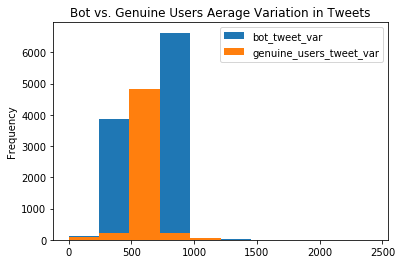

In [110]:
# after filling with mean
df_tweet_var = pd.DataFrame({'bot_tweet_var':levenshtein_data[levenshtein_data.bot==1].tweet_var,
                             'genuine_users_tweet_var': levenshtein_data[levenshtein_data.bot==0].tweet_var})
plt.figure()
df_tweet_var.plot.hist(title='Bot vs. Genuine Users Aerage Variation in Tweets')

### Visualization of Tweet Variance for Human Users and the Bot Users Types

In [111]:
trad_samp_file = os.path.join(DATASETS_DIR,'traditional_spambots_1_sample_lev.csv')
trad_samp = pd.read_csv(trad_samp_file, usecols=['id','tweet_var'])

soc1_samp_file = os.path.join(DATASETS_DIR,'social_spambots_1_sample_lev.csv')
soc1_samp = pd.read_csv(soc1_samp_file, usecols=['id','tweet_var'])

soc2_samp_file = os.path.join(DATASETS_DIR,'social_spambots_2_sample_lev.csv')
soc2_samp = pd.read_csv(soc2_samp_file, usecols=['id','tweet_var'])

soc3_samp_file = os.path.join(DATASETS_DIR,'social_spambots_3_sample_lev.csv')
soc3_samp = pd.read_csv('Datasets/social_spambots_3_sample_lev.csv', usecols=['id','tweet_var'])

fake_samp_file = os.path.join(DATASETS_DIR,'fake_followers_sample_lev.csv')
fake_samp = pd.read_csv(fake_samp_file, usecols=['id','tweet_var'])

human_samp_file = os.path.join(DATASETS_DIR,'human_100_frac0.1_lev.csv')
human_samp = pd.read_csv(human_samp_file, usecols=['id','tweet_var'])

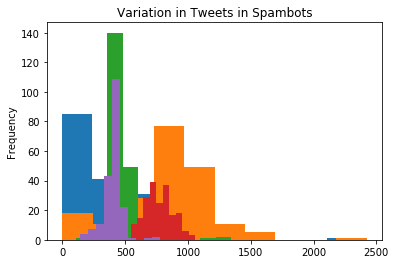

In [112]:
plt.figure()
trad_samp['tweet_var'].plot.hist(title='Variation in Tweets in Spambots')
fake_samp['tweet_var'].plot.hist()
soc1_samp['tweet_var'].plot.hist()
soc2_samp['tweet_var'].plot.hist()
soc3_samp['tweet_var'].plot.hist()

As we can see from the diagram above, most of the bot are out of the range 500 and 750 (roughly)

**statistical information of each bot type**

In [113]:
print('traditional spambots 1:')
print(trad_samp['tweet_var'].describe())
print(' ')
print('fake followers:')
fake_samp['tweet_var'].describe()
print(' ')
print('social spambots 1:')
print(soc1_samp['tweet_var'].describe())
print(' ')
print('social spambots 2:')
print(soc2_samp['tweet_var'].describe())
print(' ')
print('social spambots 3:')
print(soc3_samp['tweet_var'].describe())
print(' ')

traditional spambots 1:
count     200.000000
mean      385.058622
std       404.378679
min         0.000000
25%         0.000000
50%       339.985675
75%       640.328474
max      2341.731794
Name: tweet_var, dtype: float64
 
fake followers:
 
social spambots 1:
count     200.000000
mean      467.622703
std       118.943907
min       109.510938
25%       430.853225
50%       452.060784
75%       483.257234
max      1343.919084
Name: tweet_var, dtype: float64
 
social spambots 2:
count     200.000000
mean      768.363253
std       108.417069
min       542.275574
25%       691.291718
50%       760.613935
75%       840.493483
max      1055.846211
Name: tweet_var, dtype: float64
 
social spambots 3:
count    200.000000
mean     406.735286
std       74.188779
min      137.300949
25%      385.506559
50%      414.055154
75%      440.053096
max      776.997411
Name: tweet_var, dtype: float64
 


count     982.000000
mean      597.920582
std       258.451151
min         0.000000
25%       432.134656
50%       604.751752
75%       764.394582
max      1771.212191
Name: tweet_var, dtype: float64

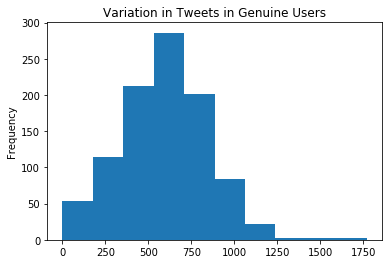

In [114]:
plt.figure()
human_samp['tweet_var'].plot.hist(title='Variation in Tweets in Genuine Users')
human_samp['tweet_var'].describe()

**Adding tweet features to the total data**

In [115]:
total_data = pd.merge(user_data,total_data, how = 'outer')

In [116]:
total_data = pd.merge(levenshtein_data,total_data, how = 'outer')

In [117]:
total_data = total_data.dropna(subset=['id'])
if 'bot' in total_data.columns or 'tweet_var' in total_data.columns:
    total_data = total_data.dropna(subset=['bot','tweet_var'])

In [118]:
tweet_features = ['p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour','500<var<750']

### Tweets - Target Feature Correlation

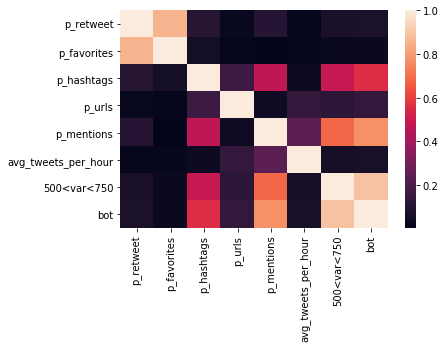

In [119]:
corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, tweet_features + ['bot'])

In [120]:
corr_mtx['bot']

p_retweet              0.078084
p_favorites            0.034111
p_hashtags             0.559934
p_urls                 0.138514
p_mentions             0.770703
avg_tweets_per_hour    0.067625
500<var<750            0.891961
bot                    1.000000
Name: bot, dtype: float64

In [121]:
tweet_features_for_models = ['p_hashtags','p_mentions','500<var<750']

As we can see, p_hashtags,p_mentions and 500<var<750 are higly correlated to our target feature

## 3.5. Description Feature

Handling 'description' field created the need to translate descriptions to English in order to create BoW - a character limited process . In addition, a long preprocessing process was used in dictionary creation, and running it takes a long time.
Therefore in some sections below we used the 'run_full_process' variable, in order to control running time.

In [122]:
try:
    from textblob import TextBlob, Word
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install textblob --user
    
try:
    import nltk
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install nltk --user

In [123]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [124]:
import Description

In [125]:
if(run_full_process):
    
    nltk.download('punkt')
    nltk.download('wordnet')
    # # # # translating description # # # # #
    description_df = Description.description_trans(description_df)
    # # # # detect language # # # # #
    description_df = Description.add_language_detection(description_df)
    # # # # creating BoW and extracting most important words from it# # # # #
    count_vectors_df, important_words = Description.find_important_words_from_bow(description_df)


### 3.5.1. Description Data

Description data includes original description column, translated description ('translation') and language detection ('description_lang'). We uploaded it, removed unnecessary columns added in csv creation and filled NA with empty string.

In [126]:
len(description_df)

16318

In [127]:
if 'Unnamed: 0' in description_df.columns:
    description_df = description_df.drop(['Unnamed: 0'], axis=1)

In [128]:
description_df['description'].fillna('', inplace = True)
description_df['translation'].fillna('', inplace = True)

In [129]:
description_df.head(5)

,id,lang,description,bot,translation,test_set_1,test_set_2,description_lang
0,1502026416,ja,15years ago X.Lines24,0,['15years ago X.Lines24'],0.0,0.0,en
1,2492782375,ja,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),0,['Maintenance apprentice local love. Economics...,0.0,0.0,ja
2,293212315,en,Let me see what your best move is!,0,['Let me see what your best move is!'],0.0,0.0,en
3,191839658,en,20. menna: #farida #nyc and the 80s actually y...,0,['20. menna: #farida #nyc and the 80s actually...,0.0,0.0,en
4,3020965143,en,Cosmetologist,0,['Cosmetologist'],0.0,0.0,en


### 3.5.2. Count Vectors

count vectors data frame includes count of each word in each description (each column is a word in the dictionary). In this section we removed unnecessary column that was created while exporting to csv.

In [130]:
count_vectors_df.head(5)

,Unnamed: 0,main_id,aaaaannndd,ab,abandon,abbbiizzz,abbe,abbindolati,abe,ability,...,티아라,필요에서,ｃａｎｔ,ｆｏｏｄｓ,ｆｕｅｌ,ｍｅｌｔ,test_set_1,test_set_2,is_bot,ｓｔｅｅｌ
0,14144,616223636,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
1,14145,616223671,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
2,14146,616223692,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
3,14147,616223734,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
4,14148,616223872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0


In [131]:
if 'Unnamed: 0' in count_vectors_df.columns:
    count_vectors_df = count_vectors_df.drop(['Unnamed: 0'], axis=1)

In [132]:
count_vectors_df.head(5)

,main_id,aaaaannndd,ab,abandon,abbbiizzz,abbe,abbindolati,abe,ability,able,...,티아라,필요에서,ｃａｎｔ,ｆｏｏｄｓ,ｆｕｅｌ,ｍｅｌｔ,test_set_1,test_set_2,is_bot,ｓｔｅｅｌ
0,616223636,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
1,616223671,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
2,616223692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
3,616223734,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0
4,616223872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1,0


### 3.5.3. Extracting Features From Description

#### Basic Feature Extraction

Fetures extracted from description are:

* Count Number of Words In a Description
* Count Number of characters In a Description
* Find Average Word Length in a Description
* Count Number of Stopwords in a Description
* Count Number of Hashtags in a Description
* Count Number of Numerics in a Description
* Count Number of Uppercase Words in a Description

In [133]:
def avg_word(sentence):
    words = sentence.split()
    if(len(words) == 0):
        return 0
    return (sum(len(word) for word in words)/len(words))

In [134]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [135]:
description_df['word_count'] = description_df['description'].apply(lambda x: len(str(x).split(" ")))
description_df['char_count'] = description_df['description'].str.len() ## this also includes spaces
description_df['avg_word'] = description_df['description'].apply(lambda x: avg_word(x))
description_df['stopwords'] = description_df['translation'].apply(lambda x: len([x for x in x.split() if x in stop]))
description_df['hashtags'] = description_df['description'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
description_df['numerics'] = description_df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
description_df['upper'] = description_df['translation'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
description_df[['translation','word_count','char_count','avg_word','stopwords','hashtags','numerics','upper']].head()

,translation,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper
0,['15years ago X.Lines24'],3,21,6.333333,0,0,0,0
1,['Maintenance apprentice local love. Economics...,3,48,15.333333,3,0,0,0
2,['Let me see what your best move is!'],8,34,3.375000,3,0,0,0
3,['20. menna: #farida #nyc and the 80s actually...,11,58,4.363636,3,2,0,0
4,['Cosmetologist'],1,13,13.000000,0,0,0,0


#### Important Words

Important words is a list of 10 most important wotds that were extracted from BoW process

In [136]:
important_words = ['job','lover','love','student','life','follow','instagram','thing','italy','live']

In [137]:
important_words_df = count_vectors_df[np.concatenate((['main_id'], important_words), axis=None)]

In [138]:
important_words_df.head(10)

,main_id,job,lover,love,student,life,follow,instagram,thing,italy,live
0,616223636,0,0,0,0,0,0,0,0,0,0
1,616223671,0,0,0,0,0,0,0,0,0,0
2,616223692,0,0,1,0,0,2,0,0,0,0
3,616223734,0,0,0,0,0,0,0,0,0,0
4,616223872,0,0,0,0,0,0,0,0,0,0
5,616223887,0,0,0,0,0,0,0,0,0,0
6,616224011,0,0,0,0,0,0,0,0,0,0
7,616224049,0,0,0,0,0,0,0,0,0,0
8,616224076,0,0,0,0,0,0,0,0,0,0
9,616224125,0,0,0,0,0,0,0,0,0,0


Merging word count vectors with basic description features

In [139]:
description_df = description_df.merge(important_words_df, left_on="id",right_on="main_id")

In [140]:
description_df.drop(["main_id"],axis=1,inplace=True)

In [141]:
description_df = description_df.rename(index=str, columns={"job": "job_appearances", "lover": "lover_appearances", "love": "love_appearances",
                                          "student": "student_appearances", "life": "life_appearances", "follow": "follow_appearances",
                                          "instagram": "instagram_appearances", "thing": "thing_appearances","italy": "italy_appearances", 
                                          "live": "live_appearances"})

#### Add 'contains_url'

If 'http' appeared in a description we mared a description as one that containes a URL

In [142]:
count_vectors_df['http'] = count_vectors_df['http'].reset_index(drop=True)
description_df['contains_url'] = 0
description_df['contains_url'] = description_df['contains_url'].reset_index(drop=True)
count_vectors_df['http'].index = description_df['contains_url'].index

In [143]:
description_df['contains_url'] = count_vectors_df['http'].apply(lambda x: 1 if x > 0 else 0)

In [144]:
description_df['contains_url'].unique()

array([0, 1])

#### Add Language Difference

Using 'description_lang' which was added to 'description_df' with Yandex service of language detection. If 'description_lang' is different from an account's language ('lang') it was marked with '1', otherwise '0'.

In [145]:
description_df['different_lang'] = description_df['description_lang'] == description_df['lang']
description_df['different_lang'] = description_df['different_lang'].apply(lambda x: 1 if x else 0)

In [146]:
description_df['different_lang'].unique()

array([0, 1])

### 3.5.4. Description Features Visualization

**Calculating Pearson Correlation**

In [147]:
description_df.columns

Index(['id', 'lang', 'description', 'bot', 'translation', 'test_set_1',
       'test_set_2', 'description_lang', 'word_count', 'char_count',
       'avg_word', 'stopwords', 'hashtags', 'numerics', 'upper',
       'job_appearances', 'lover_appearances', 'love_appearances',
       'student_appearances', 'life_appearances', 'follow_appearances',
       'instagram_appearances', 'thing_appearances', 'italy_appearances',
       'live_appearances', 'contains_url', 'different_lang'],
      dtype='object')

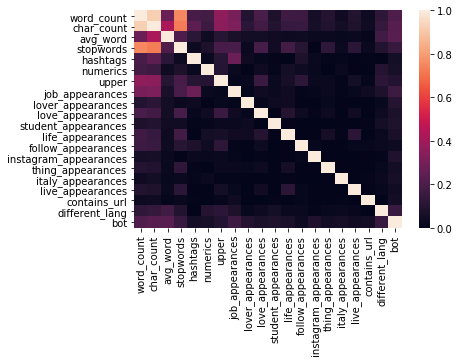

In [148]:
features_for_correlation = ['word_count','char_count','avg_word','stopwords','hashtags','numerics',
                        'upper','job_appearances','lover_appearances','love_appearances',
                        'student_appearances','life_appearances', 'follow_appearances', 'instagram_appearances',
                        'thing_appearances', 'italy_appearances', 'live_appearances', 'contains_url',
                        'different_lang','bot']

corr_mtx = General_Lib.Plot_Correlation_Matrix(description_df,features_for_correlation)

In [149]:
corr_mtx['bot']

word_count               0.204636
char_count               0.223448
avg_word                 0.231802
stopwords                0.146455
hashtags                 0.051877
numerics                 0.065483
upper                    0.090484
job_appearances          0.159020
lover_appearances        0.096801
love_appearances         0.072153
student_appearances      0.079392
life_appearances         0.067299
follow_appearances       0.033892
instagram_appearances    0.084680
thing_appearances        0.049061
italy_appearances        0.060783
live_appearances         0.044462
contains_url             0.047424
different_lang           0.149087
bot                      1.000000
Name: bot, dtype: float64

#### Important Features Distribution

In [150]:
print("Number of spambots containing the word 'job' is"
      ,description_df[description_df.bot==1]['job_appearances'].apply(lambda x: 1 if x > 0 else 0).sum() ,
      "and number of genuine accounts containing 'job' is",
      description_df[description_df.bot==0]['job_appearances'].apply(lambda x: 1 if x > 0 else 0).sum())

Number of spambots containing the word 'job' is 1392 and number of genuine accounts containing 'job' is 15


In [151]:
print("Number of spambots containing the word 'follow' is",
      description_df[description_df.bot==1]['follow_appearances'].apply(lambda x: 1 if x > 0 else 0).sum() ,
      "and number of genuine accounts containing 'follow' is",
      description_df[description_df.bot==0]['follow_appearances'].apply(lambda x: 1 if x > 0 else 0).sum())

Number of spambots containing the word 'follow' is 279 and number of genuine accounts containing 'follow' is 84


In [152]:
print("Number of accounts with different language than declared is:", description_df[description_df.bot==0]['different_lang'].sum())

Number of accounts with different language than declared is: 4519


#### Merge Final Description Features with Total Data

In [153]:
description_features = ['id','word_count','char_count','avg_word','stopwords','hashtags','numerics',
                        'upper','job_appearances','lover_appearances','love_appearances',
                        'student_appearances','life_appearances', 'follow_appearances', 'instagram_appearances',
                        'thing_appearances', 'italy_appearances', 'live_appearances', 'contains_url', 'different_lang']

In [154]:
description_features_for_model = ['word_count','avg_word','stopwords','job_appearances','follow_appearances','different_lang']

In [155]:
description_df[description_features].head(5)

,id,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,job_appearances,lover_appearances,love_appearances,student_appearances,life_appearances,follow_appearances,instagram_appearances,thing_appearances,italy_appearances,live_appearances,contains_url,different_lang
0,1502026416,3,21,6.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2492782375,3,48,15.333333,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,293212315,8,34,3.375000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,191839658,11,58,4.363636,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3020965143,1,13,13.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [156]:
total_data = pd.merge(description_df[description_features],total_data, how = 'outer')

In [157]:
total_data.shape

(16318, 158)

In [158]:
total_data.dtypes

id                                              int64
word_count                                      int64
char_count                                      int64
avg_word                                      float64
stopwords                                       int64
hashtags                                        int64
numerics                                        int64
upper                                           int64
job_appearances                                 int64
lover_appearances                               int64
love_appearances                                int64
student_appearances                             int64
life_appearances                                int64
follow_appearances                              int64
instagram_appearances                           int64
thing_appearances                               int64
italy_appearances                               int64
live_appearances                                int64
contains_url                

# 4. Data Visualization & Analysis

**Most visualization work is done on each part above**

## 4.1. Correlations

On the section below we choose user features with the highest correlation to target. For tweets and description features we chose high correlated features above.

### Target - Feature Correlations: User Features

In [159]:
methods = ['pearson', 'kendall', 'spearman']
features_list_to_drop = tweet_features + description_features + ['bot']
General_Lib.Print_Target_Features_Correlation(total_data, 
                                              methods, 
                                              'bot', 
                                              features_list_to_drop)

---------------Target - Feature Correlations---------------

*** pearson best 10 correlation results ***
is_favourite -0.8213190694808836
statuses_count_binning -0.7152237317990714
profile_banner_url_len -0.6334670314652072
profile_banner_url_most_common 0.6308267000370451
bin_followers_count -0.5266178365117593
profile_image_url_https_unique_dist 0.4905547960226689
geo_enabled -0.4850199497669213
time_zone_most_common 0.4360946909896993
time_zone_unique -0.4014360973460214
time_zone_unique_mode -0.4014360973460214
profile_image_url_https_unique 0.39264786918103084

*** kendall best 10 correlation results ***
is_favourite -0.8213190694808825
favourites_count -0.7844299933781393
statuses_count_binning -0.6877574852658319
profile_banner_url_most_common 0.6308267000370429
profile_banner_url_len -0.6085600600354579
statuses_count -0.5342907031773665
geo_enabled -0.4850199497669217
bin_followers_count -0.47066705357482563
profile_banner_url_unique -0.4472733046087789
profile_banner_url_uniq

In [160]:
top_base_correlated_features = ['is_favourite', 
                                'statuses_count_binning',
                                'bin_followers_count', 
                                'profile_background_color_unique_dist',
                                'is_utc_offset',
                                'is_top_month',
                                'geo_enabled',
                                'time_zone_most_common',
                                'profile_banner_url_len']

In [161]:
total_features_to_use = top_base_correlated_features + tweet_features_for_models + description_features_for_model

# 5. Data Division

Dividing data by binary columns 'test_set_1' (we use it as validation set) and 'test_set_2' (we use it by test set). When marked with '1' an account belongs to a test set, otherwise, belongs to training set.

In [162]:
train_data, test_set_1, test_set_2 = General_Lib.train_test_division(total_data)

# 6. Model

**Dividing train data into X values and y values**

In [163]:
y_train = train_data['bot']
x_train = train_data[total_features_to_use]

## 6.1. Decision Trees

In [164]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
DTclassifier = DecisionTreeClassifier(criterion='entropy', class_weight = {0:1,1:2})  
DTclassifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 6.2. Random forest

In [165]:
from sklearn.ensemble import RandomForestRegressor
RFclassifier = RandomForestRegressor(n_estimators=20, random_state=0)  
RFclassifier.fit(x_train, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [166]:
feature_importances = pd.DataFrame(RFclassifier.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [167]:
feature_importances

,importance
500<var<750,0.779561
p_mentions,0.081408
p_hashtags,0.022535
avg_word,0.021712
is_utc_offset,0.020461
is_favourite,0.018509
profile_banner_url_len,0.014911
word_count,0.012597
time_zone_most_common,0.006671
profile_background_color_unique_dist,0.006587


## 6.3. Logistic Resression

In [168]:
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression(solver='liblinear')
LRclassifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [169]:
LRclassifier.coef_ 

array([[-1.80213068e+00, -5.07089576e-01, -3.71178133e-02,
         2.32151162e-03, -2.17187768e+00,  5.81630039e-01,
        -7.95824465e-01,  3.63135242e-01, -3.50890897e-02,
        -1.55578350e+00, -2.48767266e+00, -4.68068107e+00,
         1.81816930e-02, -1.99295847e-02, -1.55634687e-01,
         2.56326019e+00,  4.11349083e-01,  4.20903407e-01]])

# 7. Model Evaluation

In [170]:
import Evaluation_Results_Lib

**Dividing validation and test data into X values and y values**

In [171]:
y_validation = test_set_1['bot']
x_validation = test_set_1[total_features_to_use]

In [172]:
y_test = test_set_2['bot']
x_test = test_set_2[total_features_to_use]

## 7.1. Decision Trees

### 7.1.1. Validation Set

In [173]:
y_pred_descisionTree = DTclassifier.predict(x_validation)  
y_pred_descisionTree_probs = DTclassifier.predict_proba(x_validation)

In [174]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_descisionTree,  
                                     classifier_name = 'Decision_Tree')

Confusion Matrix :
[[991   9]
 [ 44 947]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1000
           1       0.99      0.96      0.97       991

   micro avg       0.97      0.97      0.97      1991
   macro avg       0.97      0.97      0.97      1991
weighted avg       0.97      0.97      0.97      1991

Accuracy :  0.9733802109492717
MCC :  0.9473367637911242
Specificity :  0.9556004036326943


### 7.1.2. Test Set

In [175]:
y_pred_descisionTree_test = DTclassifier.predict(x_test)  
y_pred_descisionTree_probs_test = DTclassifier.predict_proba(x_test)

In [176]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_descisionTree_test, 
                                     classifier_name = 'Decision_Tree')

Confusion Matrix :
[[485   5]
 [ 22 442]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9716981132075472
MCC :  0.943900745398075
Specificity :  0.9525862068965517


## 7.2. Random forest

### 7.2.1. Validation Set

In [177]:
# Random forest
y_pred_forest = RFclassifier.predict(x_validation)
y_pred_forest_probs = y_pred_forest

In [178]:
y_pred_forest = y_pred_forest >=0.5
y_pred_forest = y_pred_forest.astype(int)

In [179]:
np.unique(y_pred_forest)

array([0, 1])

In [180]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_forest, 
                                     classifier_name = 'Random_Forest')

Confusion Matrix :
[[995   5]
 [ 56 935]]
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.99      0.94      0.97       991

   micro avg       0.97      0.97      0.97      1991
   macro avg       0.97      0.97      0.97      1991
weighted avg       0.97      0.97      0.97      1991

Accuracy :  0.9693621295831241
MCC :  0.9399437192292136
Specificity :  0.9434914228052472


### 7.2.2. Test Set

In [181]:
# Random forest
y_pred_forest_test = RFclassifier.predict(x_test)
y_pred_forest_probs_test = y_pred_forest_test

In [182]:
y_pred_forest_test = y_pred_forest_test >=0.5
y_pred_forest_test = y_pred_forest_test.astype(int)

In [183]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_forest_test,  
                                     classifier_name = 'Random_Forest')

Confusion Matrix :
[[486   4]
 [ 21 443]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9737945492662474
MCC :  0.948103495846641
Specificity :  0.9547413793103449


## 7.3. Logistic regression

### 7.3.1. Validation Set

In [184]:
y_pred_lr = LRclassifier.predict(x_validation)
y_pred_lr_probs = LRclassifier.predict_proba(x_validation)

In [185]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_lr, 
                                     classifier_name = 'Logistic_Regression')

Confusion Matrix :
[[997   3]
 [ 65 926]]
Classification Report :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1000
           1       1.00      0.93      0.96       991

   micro avg       0.97      0.97      0.97      1991
   macro avg       0.97      0.97      0.97      1991
weighted avg       0.97      0.97      0.97      1991

Accuracy :  0.9658463083877449
MCC :  0.9334852550464057
Specificity :  0.934409687184662


### 7.3.2. Test Set

In [186]:
y_pred_lr_test = LRclassifier.predict(x_test)
y_pred_lr_probs_test = LRclassifier.predict_proba(x_test)

In [187]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_lr_test, 
                                     classifier_name = 'Logistic_Regression')

Confusion Matrix :
[[488   2]
 [ 22 442]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       490
           1       1.00      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.98      0.97      0.97       954
weighted avg       0.98      0.97      0.97       954

Accuracy :  0.9748427672955975
MCC :  0.9504294542581528
Specificity :  0.9525862068965517


## 7.4. Collective Model

This model classifies by the majority in all models

### 7.4.1. Validation Set

In [188]:
res_dict = {'Decision_Trees':y_pred_descisionTree, 
            'Random_Forest':y_pred_forest,
            'LG':y_pred_lr
           }

results = pd.DataFrame(data = res_dict)
results['Collective_Model'] = results.mode(axis = 1)[0]

In [189]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     results['Collective_Model'],  
                                     classifier_name = 'Collective_Model')

Confusion Matrix :
[[996   4]
 [ 45 946]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1000
           1       1.00      0.95      0.97       991

   micro avg       0.98      0.98      0.98      1991
   macro avg       0.98      0.98      0.98      1991
weighted avg       0.98      0.98      0.98      1991

Accuracy :  0.9753892516323456
MCC :  0.9515760548871668
Specificity :  0.9545913218970736


### 7.4.2. Test Set

In [190]:
res_dict_test = {'Decision_Trees':y_pred_descisionTree_test, 
                 'Random_Forest':y_pred_forest_test,
                 'LG':y_pred_lr_test
                }

results_test = pd.DataFrame(data = res_dict_test)
results_test['Collective_Model'] = results_test.mode(axis = 1)[0]

In [191]:
Evaluation_Results_Lib.print_results(y_test, 
                                     results_test['Collective_Model'],  
                                     classifier_name = 'Collective_Model')

Confusion Matrix :
[[487   3]
 [ 22 442]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.98      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9737945492662474
MCC :  0.9482484079109248
Specificity :  0.9525862068965517


## 7.5. ROC\AUC

### 7.5.1 Validation Set 

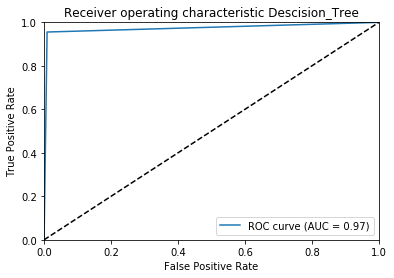

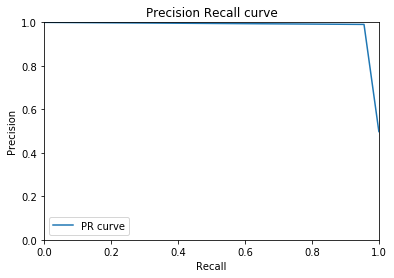

In [192]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_descisionTree_probs[:,1], 
                                    'Descision_Tree')

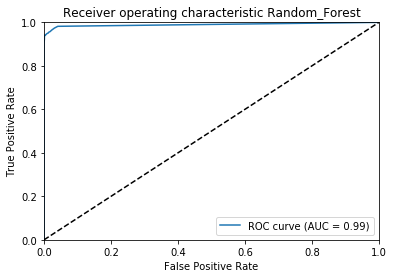

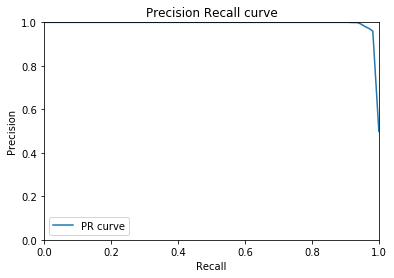

In [193]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_forest_probs, 
                                    'Random_Forest')

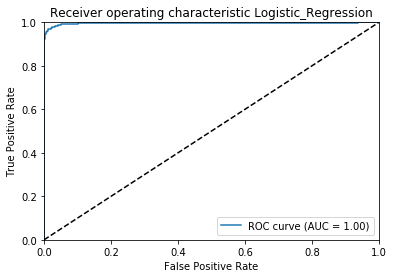

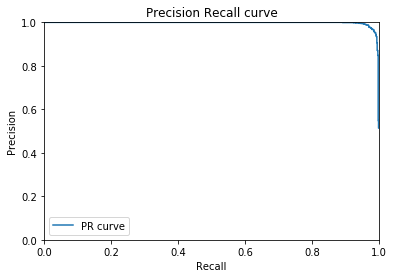

In [194]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_lr_probs[:,1], 
                                    'Logistic_Regression')

### 7.5.2. Test Set 

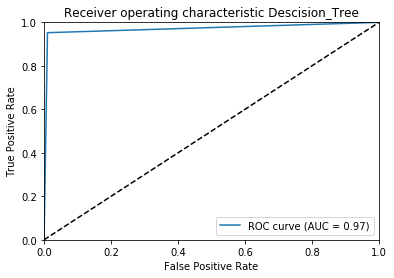

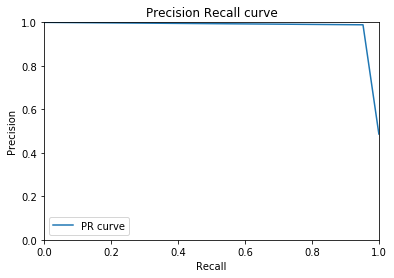

In [195]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_descisionTree_probs_test[:,1], 
                                    'Descision_Tree')

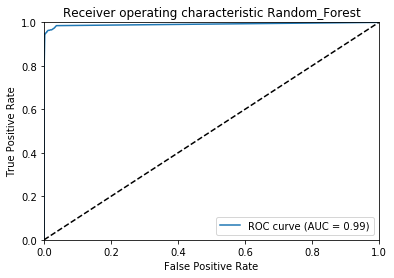

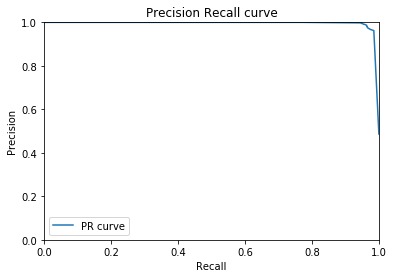

In [196]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_forest_probs_test, 
                                    'Random_Forest')

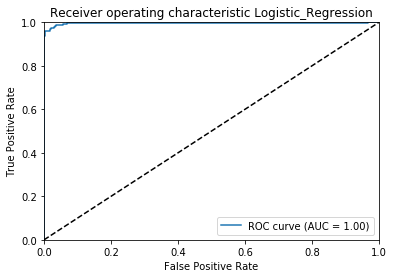

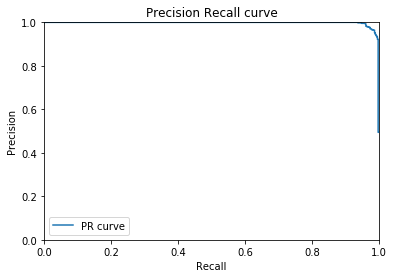

In [197]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_lr_probs_test[:,1], 
                                    'Logistic_Regression')

# 7.6. Robustness Test : K-Fold For the Best Model

Cross-validation with the model that yields the best results : **Collective Model**

In [198]:
kfold = KFold(n_splits=10, shuffle = True)
rfc = RandomForestRegressor(n_estimators=20, random_state=0)
lrc = LogisticRegression(solver='liblinear')
dtc = DecisionTreeClassifier(criterion='entropy', class_weight = {0:1,1:2})
for train_indices, test_indices in kfold.split(x_train):
    rfc.fit(x_train.iloc[train_indices], y_train.iloc[train_indices])
    lrc.fit(x_train.iloc[train_indices], y_train.iloc[train_indices])
    dtc.fit(x_train.iloc[train_indices], y_train.iloc[train_indices])
    y_pred_rf = rfc.predict(x_train.iloc[test_indices])
    y_pred_rf = y_pred_rf >=0.5
    y_pred_rf = y_pred_rf.astype(int)
    y_pred_lr = lrc.predict(x_train.iloc[test_indices])
    y_pred_dt = dtc.predict(x_train.iloc[test_indices])
    r_dict = {'Decision_Trees':y_pred_dt, 
            'Random_Forest':y_pred_rf,
            'LG':y_pred_lr
           }
    r = pd.DataFrame(data = r_dict)
    r['Collective_Model'] = r.mode(axis = 1)[0]
    Evaluation_Results_Lib.print_results(y_train.iloc[test_indices], r['Collective_Model'], 
                                         classifier_name = 'Collective Model')
    print("------------------------------------------------------------------------")

Confusion Matrix :
[[436   8]
 [ 13 930]]
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       444
           1       0.99      0.99      0.99       943

   micro avg       0.98      0.98      0.98      1387
   macro avg       0.98      0.98      0.98      1387
weighted avg       0.98      0.98      0.98      1387

Accuracy :  0.9848594087959625
MCC :  0.9653529140596119
Specificity :  0.9862142099681867
------------------------------------------------------------------------
Confusion Matrix :
[[457   8]
 [ 10 912]]
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       465
           1       0.99      0.99      0.99       922

   micro avg       0.99      0.99      0.99      1387
   macro avg       0.98      0.99      0.99      1387
weighted avg       0.99      0.99      0.99      1387

Accuracy :  0.9870223503965393
MCC :  0.9709198461

As seen above, results are consistent for each fold, hence the best model is robust. 